## Preparation

### Load data

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics import mean_squared_error
import sklearn.linear_model as skl
import sklearn.preprocessing as skp
import os
from matplotlib import pyplot as plt
import copy as cp
import scipy.optimize as opt

BLUE_LIGHT = str('#00CCFF') 
GREEN_LIGHT = str('#00CC00')
RED_LIGHT = str('#FF3333')
RED_BOLD = str('#770000')
YELLOW_LIGHT = str('#FFCC00')
YELLOW_BOLD = str('#C7C300')
BLACK = 'black'

DATA_DIR = 'data'

In [2]:
data_df = pd.read_csv(os.path.join(DATA_DIR, 'covid_data.csv'))

data_df.head()

,date,case_by_day,case_by_time,death_by_day,once_injected_by_time,twice_injected_by_time
0,0,5,5,0,0,0
1,1,8,13,0,0,0
2,2,45,58,0,0,0
3,3,16,74,0,0,0
4,4,14,88,0,0,0


### Visualize

In [3]:
# Smooth 7 day - average
def smooth_helper(data_array, k = 7):
    copy = cp.deepcopy(data_array)
    for i in range(int(k/2), len(data_array) - int(k/2)):
        temp = 0
        for j in range(k):
            temp += float(copy[i + j - int(k/2)] / k)
        copy[i] = int(temp)
    return copy.reshape(-1,)

def smooth(data_array, k = 7):
    copy = cp.deepcopy(data_array)
    for col_index in range(data_array.shape[1]):
        copy[:,col_index] = smooth_helper(copy[:,col_index], k)
    return copy

In [4]:
# Draw
def drawCase(X, Y, color, X_col=[], Y_col=[], title = 'Graph'):

        plt.figure(figsize=(9,3))
        
        ax = plt.axes()
        #ax.grid(linewidth=0.4, color='#8f8f8f') 
        
        #ax.set_facecolor("black") 
        ax.set_xlabel('\nDate',size=19,color='#4bb4f2')
        ax.set_ylabel(title + '\n',
                size=17,color='#4bb4f2')
        
        
        ax.bar(X_col, Y_col, color='#4bb4f2')
        ax.plot(X,Y,
                color=color,
                linewidth=3,
                markersize=3,
                marker='o',
                markeredgecolor='white')

In [5]:
X_date = np.array(data_df['date'].values)

Y_cases =  np.array(data_df['case_by_day'].values)
Y_cumulative_cases = np.array(data_df['case_by_time'].values)
Y_deaths = np.array(data_df['death_by_day'].values)

Y_vaccine1 = np.array(data_df['once_injected_by_time'].values)
Y_vaccine2 = np.array(data_df['twice_injected_by_time'].values)

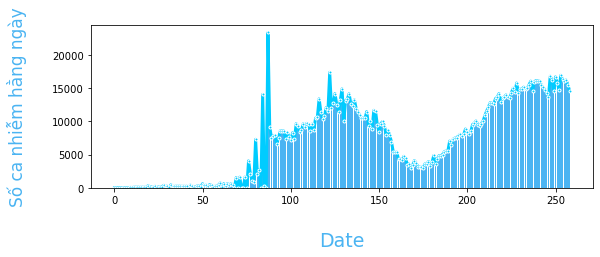

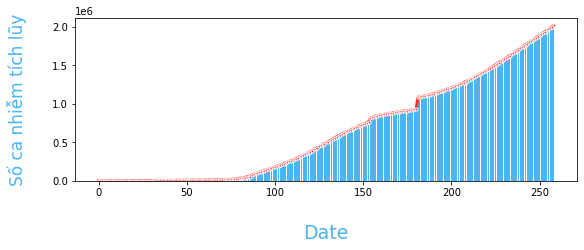

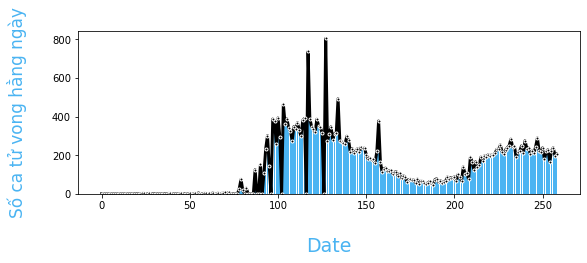

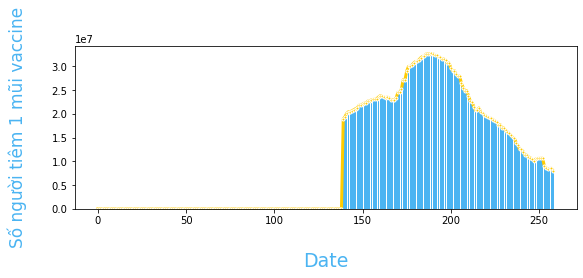

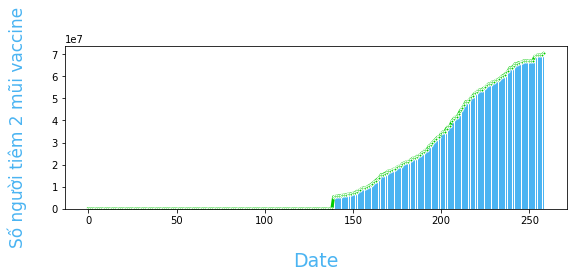

In [6]:
drawCase(X_date, Y_cases, BLUE_LIGHT, X_date, Y_cases, title ='Số ca nhiễm hằng ngày')
drawCase(X_date, Y_cumulative_cases, RED_LIGHT, X_date, Y_cumulative_cases, title ='Số ca nhiễm tích lũy')
drawCase(X_date, Y_deaths, BLACK, X_date, Y_deaths, title ='Số ca tử vong hằng ngày')
drawCase(X_date, Y_vaccine1, YELLOW_LIGHT, X_date, Y_vaccine1, title ='Số người tiêm 1 mũi vaccine')
drawCase(X_date, Y_vaccine2, GREEN_LIGHT, X_date, Y_vaccine2, title ='Số người tiêm 2 mũi vaccine')

#### Smooth graph

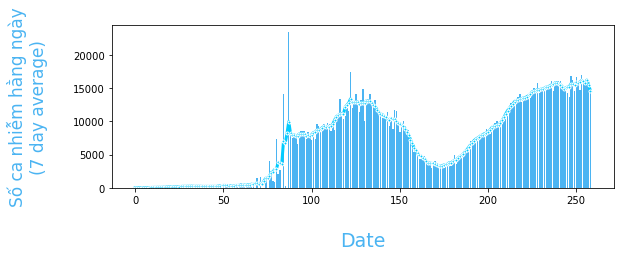

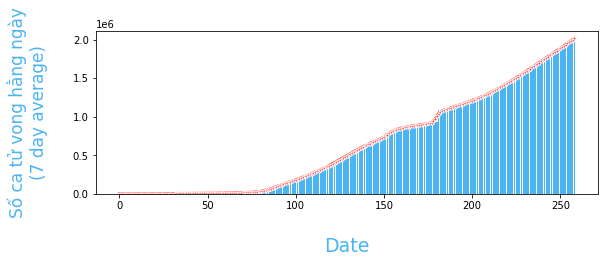

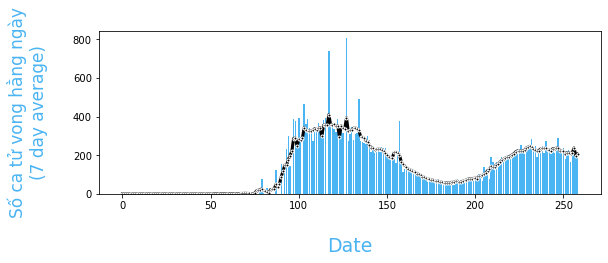

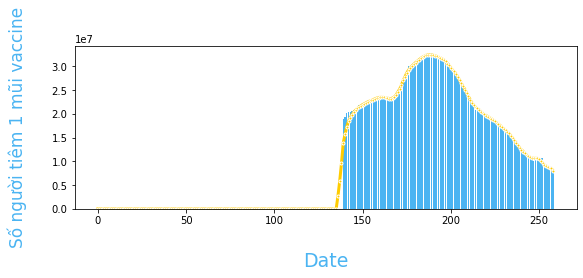

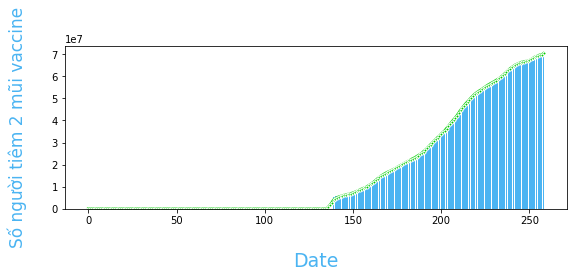

In [7]:
Y_cases_smooth = smooth(Y_cases.reshape(-1,1)).reshape(-1,)
Y_cumulative_cases_smooth = smooth(Y_cumulative_cases.reshape(-1,1)).reshape(-1,)
Y_deaths_smooth = smooth(Y_deaths.reshape(-1,1)).reshape(-1,)
Y_vaccine1_smooth = smooth(Y_vaccine1.reshape(-1,1)).reshape(-1,)
Y_vaccine2_smooth = smooth(Y_vaccine2.reshape(-1,1)).reshape(-1,)

drawCase(X_date, Y_cases_smooth, BLUE_LIGHT, X_date, Y_cases, title ='Số ca nhiễm hằng ngày\n(7 day average)')
drawCase(X_date, Y_cumulative_cases_smooth, RED_LIGHT, X_date, Y_cumulative_cases, title ='Số ca tử vong hằng ngày\n(7 day average)')
drawCase(X_date, Y_deaths_smooth, BLACK, X_date, Y_deaths, title ='Số ca tử vong hằng ngày\n(7 day average)')
drawCase(X_date, Y_vaccine1_smooth, YELLOW_LIGHT, X_date, Y_vaccine1, title ='Số người tiêm 1 mũi vaccine')
drawCase(X_date, Y_vaccine2_smooth, GREEN_LIGHT, X_date, Y_vaccine2, title ='Số người tiêm 2 mũi vaccine')

## Method

### Linear Regression

In [8]:
DAY = 350
TRAIN = 240
TEST = 259

x_data = data_df[['date', 'case_by_time']].values
x_data[:,1] = smooth(x_data[:,1].reshape(-1, 1)).reshape(-1,)

x_train = x_data[:TRAIN, :]
x_test = x_data[TRAIN:, :]

y_cases_train = Y_cases_smooth[:TRAIN]
y_deaths_train = Y_deaths_smooth[:TRAIN]
y_cases_test = Y_cases_smooth[TRAIN:]
y_deaths_test = Y_deaths_smooth[TRAIN:]

future = np.array(range(DAY))

def lossLR(y, y_predict):
    loss = np.sqrt(np.mean((y_predict - y)**2))
    return loss

#### With date and total cases

In [9]:
poly = skp.PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(x_train)

regr_cases = skl.LinearRegression()
regr_cases.fit(X_poly, y_cases_train)

regr_deaths = skl.LinearRegression()
regr_deaths.fit(X_poly, y_deaths_train)

LinearRegression()

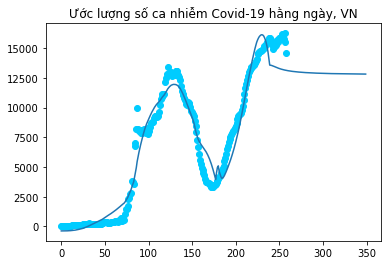

 Dự đoán số ca nhiễm hằng ngày
 RMSE test:  2297.321560623196
-------------------------------------------------------


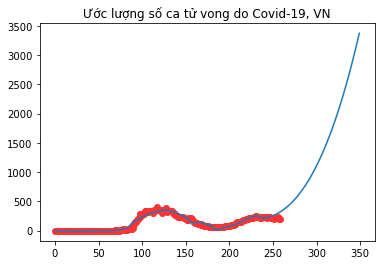

 Dự đoán số ca tử vong hằng ngày
 RMSE test:  53.17170913625722
-------------------------------------------------------


In [10]:
ld = TRAIN #X.shape[0]
predict = np.zeros((DAY, x_train.shape[-1]), dtype=int)
predict[:ld,:] = x_train[:ld,:]

for i in range(ld, len(predict)):
    day = i
    total_case = predict[i-1,1] + int(regr_cases.predict(poly.fit_transform([predict[i-1,:]])))

    predict[i,0] = day
    try:
        predict[i,1] = total_case
    except:
        pass


y_cases_predict_test = regr_cases.predict(poly.fit_transform(predict))[TRAIN:TEST]
plt.scatter(X_date, Y_cases_smooth, c=BLUE_LIGHT)
plt.plot(future, regr_cases.predict(poly.fit_transform(predict)))
plt.title("Ước lượng số ca nhiễm Covid-19 hằng ngày, VN")
plt.show()
print(' Dự đoán số ca nhiễm hằng ngày')
print(' RMSE test: ', lossLR(y_cases_test, y_cases_predict_test))
print("-------------------------------------------------------")


y_deaths_predict_test = regr_deaths.predict(poly.fit_transform(predict))[TRAIN:TEST]
plt.scatter(X_date, Y_deaths_smooth, c=RED_LIGHT)
plt.plot(future, regr_deaths.predict(poly.fit_transform(predict)))
plt.title("Ước lượng số ca tử vong do Covid-19, VN")
plt.show()
print(' Dự đoán số ca tử vong hằng ngày')
print(' RMSE test: ', lossLR(y_deaths_test, y_deaths_predict_test))
print("-------------------------------------------------------")

### Math

In [11]:
DAY = 600
TRAIN = 240

x = X_date
y = Y_cumulative_cases_smooth

x_train = x[:TRAIN]
y_train = y[:TRAIN]

x_test = x[TRAIN:]
y_test = y[TRAIN:]

print('Số phần tử train:', x_train.shape[0])
print('Số phần tử test:', x_test.shape[0])
future = np.array(range(DAY))

Số phần tử train: 240
Số phần tử test: 19


#### Exponential Model

In [12]:
# Exponential Model
def exponentModel(x, p, N0, x0):
    return N0*(1+p)**(x-x0)

# Logistic model
def logisticModelV1(x, a, b, c):
    return c / (1 + np.exp(-a*(x-b)))

def logisticModelV2(x, a, b, c, alpha):
    return c / ((1+np.exp(-a*(x-b)))**alpha)

# Gompertz model
def gompertzModel(x, a, b, c):
    return a*np.exp(-b*np.exp(-c*x))

def doubleGompertzModel(x, a1, b1, c1, a2, b2, c2):
    return a1*np.exp(-b1*np.exp(-c1*x)) + a2*np.exp(-b2*np.exp(-c2*x))


In [13]:
def drawHist(x, y, pars, model, name):
    predict = model(future, *pars)
    plt.figure(1, figsize=(7,4))
    plt.plot(x, y, color=RED_LIGHT, linewidth=3, markersize=7, marker='o', markeredgecolor='white', label='real')
    plt.title(name)
    plt.plot(future, predict, 'g-', label=predict)
    plt.xlim(min(future), max(future))
    plt.ylim(min(predict), max(predict) + 500000)
    plt.show()

def loss(x, y, pars, model):
    predict = model(x, *pars)
    loss = np.sqrt(np.mean((predict - y)**2))
    return loss


In [14]:
fitExp = opt.curve_fit(exponentModel, x_train, y_train, maxfev=100000)

fitLogic1 = opt.curve_fit(logisticModelV1, x_train, y_train, maxfev=100000)

fitLogic2 = opt.curve_fit(logisticModelV2, x_train, y_train, maxfev=100000)

fitGompert = opt.curve_fit(gompertzModel, x_train, y_train, maxfev=100000)

fitDoubleGompert = opt.curve_fit(doubleGompertzModel, x_train, y_train, maxfev=100000)

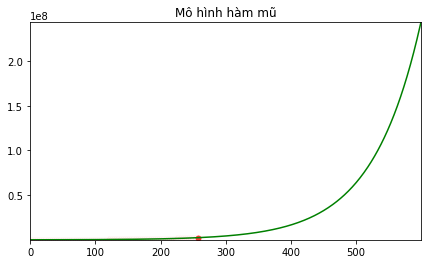

Mô hình hàm mũ
RMSE train:  126762.13760162139
RMSE test:  341904.8396826623
-------------------------------------------------------


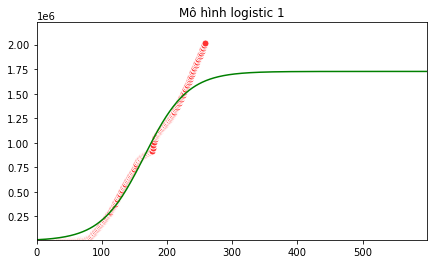

Mô hình logistic 1
RMSE train:  56297.75377010283
RMSE test:  281543.21074513515
-------------------------------------------------------


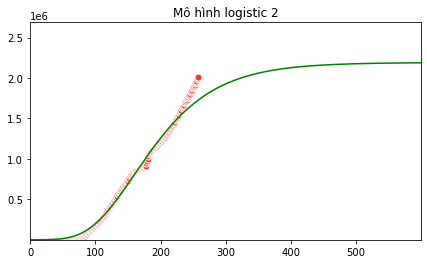

Mô hình logistic 2
RMSE train:  36871.75603418844
RMSE test:  206783.87870249862
-------------------------------------------------------


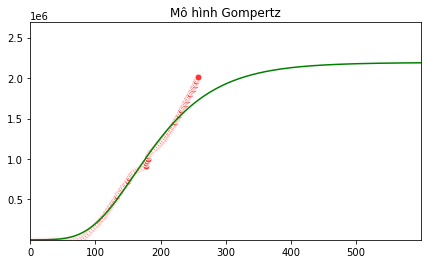

Mô hình tổng Gompertz
RMSE train:  36870.55231601871
RMSE test:  206754.82085240426
-------------------------------------------------------


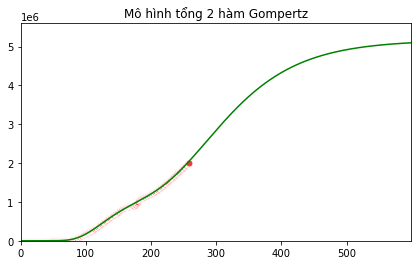

Mô hình tổng 2 hàm Gompertz
RMSE train:  14231.991823736524
RMSE test:  14027.081781220117
-------------------------------------------------------


In [15]:
drawHist(x, y, fitExp[0], exponentModel, 'Mô hình hàm mũ')
print('Mô hình hàm mũ')
print('RMSE train: ', loss(x_train, y_train, fitExp[0], exponentModel))
print('RMSE test: ', loss(x_test, y_test, fitExp[0], exponentModel))
print("-------------------------------------------------------")

##############################################################################
drawHist(x, y, fitLogic1[0], logisticModelV1, 'Mô hình logistic 1')
print('Mô hình logistic 1')
print('RMSE train: ', loss(x_train, y_train, fitLogic1[0], logisticModelV1))
print('RMSE test: ', loss(x_test, y_test, fitLogic1[0], logisticModelV1))
print("-------------------------------------------------------")


##############################################################################
drawHist(x, y, fitLogic2[0], logisticModelV2, 'Mô hình logistic 2')
print('Mô hình logistic 2')
print('RMSE train: ', loss(x_train, y_train, fitLogic2[0], logisticModelV2))
print('RMSE test: ', loss(x_test, y_test, fitLogic2[0], logisticModelV2))
print("-------------------------------------------------------")


##############################################################################
drawHist(x, y, fitGompert[0], gompertzModel, 'Mô hình Gompertz')
print('Mô hình tổng Gompertz')
print('RMSE train: ', loss(x_train, y_train, fitGompert[0], gompertzModel))
print('RMSE test: ', loss(x_test, y_test, fitGompert[0], gompertzModel))
print("-------------------------------------------------------")

##############################################################################
drawHist(x, y, fitDoubleGompert[0], doubleGompertzModel, 'Mô hình tổng 2 hàm Gompertz')
print('Mô hình tổng 2 hàm Gompertz')
print('RMSE train: ', loss(x_train, y_train, fitDoubleGompert[0], doubleGompertzModel))
print('RMSE test: ', loss(x_test, y_test, fitDoubleGompert[0], doubleGompertzModel))
print("-------------------------------------------------------")